In [1]:
import json
from collections import Counter, defaultdict

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
plt.rcParams["font.size"] = 14

In [4]:
TRAIN_PATH = "work/dataset/train_question.json"
DEV_PATH = "work/dataset/dev_question.json"
TEST_PATH = "work/dataset/test_question.json"

In [5]:
train = pd.read_json(open(TRAIN_PATH).read(), orient='records', lines=True)

In [6]:
dev = pd.read_json(open(DEV_PATH).read(), orient='records', lines=True)

In [7]:
test = pd.read_json(open(TEST_PATH).read(), orient='records', lines=True)

In [8]:
train.head()

,qanta_id,text,entity,text_unit
0,0,After this character relates a story about how...,Queequeg,question
1,1,The oldest document written in this language i...,Romanian_language,question
2,2,This state's largest city endured an 1855 Rum ...,Maine,question
3,3,"In one work, this man provides definitions for...",Charles_Sanders_Peirce,question
4,4,One family in this work flees France after res...,Frankenstein,question


In [9]:
train_counts = train['entity'].value_counts()

In [10]:
train_counts

Japan                           99
China                           97
Australia                       97
Spain                           89
Brazil                          87
                                ..
Spherical_coordinate_system      1
Shraddhadeva_Manu                1
Electron_degeneracy_pressure     1
SpaceX                           1
Mass_wasting                     1
Name: entity, Length: 25969, dtype: int64

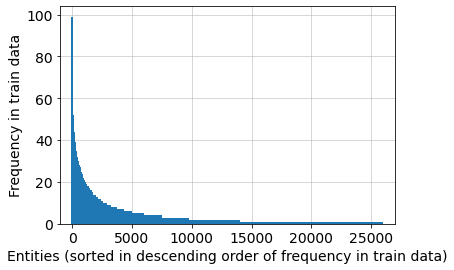

In [11]:
plt.figure()
ax = train_counts.plot.bar(width=100.0, rot=0)
ax.set_xticks(np.arange(0,len(train_counts),5000))
ax.set_xticklabels(np.arange(0,len(train_counts),5000))
ax.grid(which='major', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Entities (sorted in descending order of frequency in train data)')
ax.set_ylabel('Frequency in train data')
ax.set_xlim(-1000, len(train_counts)+1000)
plt.savefig('images/train_freq.pdf', bbox_inches='tight')

In [12]:
num_unanswerable = 0
for _, item in test.iterrows():
    entity = item['entity']
    if entity not in train_counts:
        num_unanswerable += 1
    
print(num_unanswerable)
print(1 - num_unanswerable / len(test)) 

648
0.8421052631578947


In [13]:
QUIZ_PREDICTION_PATH = 'work/quiz/bert-base/prediction_test_question.json'
WIKI_QUIZ_PREDICTION_PATH = 'work/wiki_quiz/bert-base/prediction_test_question.json'

In [14]:
def make_accuracy_bins(fpath):
    freq_accuracy_bins = defaultdict(list)
    sid_accuracy_bins = defaultdict(list)
    
    with open(fpath) as f:
        for line in f:
            pred_data = json.loads(line)
            pred_answer = pred_data['top1_entity']
            correct_answer = pred_data['metadata']['entity']
            sid = pred_data['metadata'].get('sentence_index')
            
            accuracy = int(pred_answer == correct_answer)

            if correct_answer in train_counts:
                freq = train_counts[correct_answer]
            else:
                freq = 0
                
            freq_label = '6+' if freq >= 6 else str(freq)
            freq_accuracy_bins[freq_label].append(accuracy)
            
            if sid is not None:
                sid += 1  # 0-origin -> 1-origin
                sid_label = '7+' if sid >= 7 else str(sid)
                sid_accuracy_bins[sid_label].append(accuracy)
    
    freq_mean_accuracies = defaultdict(float)
    for label in ['0', '1', '2', '3', '4', '5', '6+']:
        if label in freq_accuracy_bins:
            accuracies = freq_accuracy_bins[label]
            assert len(accuracies) > 0
            mean_accuracy = sum(accuracies) / len(accuracies)
            freq_mean_accuracies[label] = mean_accuracy
    
    sid_mean_accuracies = defaultdict(float)
    for label in ['1', '2', '3', '4', '5', '6', '7+']:
        if label in sid_accuracy_bins:
            accuracies = sid_accuracy_bins[label]
            assert len(accuracies) > 0
            mean_accuracy = sum(accuracies) / len(accuracies)
            sid_mean_accuracies[label] = mean_accuracy
            
    return freq_mean_accuracies, sid_mean_accuracies

In [15]:
quiz_freq_accuracies, _ = make_accuracy_bins(QUIZ_PREDICTION_PATH)
wiki_quiz_freq_accuracies, _ = make_accuracy_bins(WIKI_QUIZ_PREDICTION_PATH)

In [16]:
freq_labels = ['1', '2', '3', '4', '5', '6+']
xlnet_freq_accuracies_dict = {
    'Qanta': [quiz_freq_accuracies[label] for label in freq_labels],
    r'Wiki$\rightarrow$Qanta': [wiki_quiz_freq_accuracies[label] for label in freq_labels]
}
freq_accuracies_df = pd.DataFrame(data=xlnet_freq_accuracies_dict, index=freq_labels)

In [17]:
freq_accuracies_df

,Qanta,Wiki$\rightarrow$Qanta
1,0.286501,0.468320
2,0.511029,0.661765
3,0.612150,0.714953
4,0.725275,0.774725
5,0.744681,0.773050
6+,0.867338,0.883975


<Figure size 432x288 with 0 Axes>

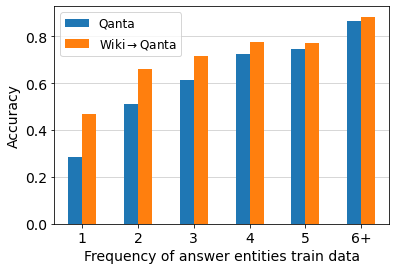

In [18]:
plt.figure()
ax = freq_accuracies_df.plot.bar(rot=0)
ax.grid(which='major', axis='y', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Frequency of answer entities train data')
ax.set_ylabel('Accuracy')
ax.legend(fontsize=12)
plt.savefig('images/accuracy_freq.pdf', bbox_inches='tight')

In [19]:
QUIZ_SENTENCE_PREDICTION_PATH = 'work/quiz/bert-base/prediction_test_sentence.json'
WIKI_QUIZ_SENTENCE_PREDICTION_PATH = 'work/wiki_quiz/bert-base/prediction_test_sentence.json'

In [20]:
_, quiz_sid_accuracies = make_accuracy_bins(QUIZ_SENTENCE_PREDICTION_PATH)
_, wiki_quiz_sid_accuracies = make_accuracy_bins(WIKI_QUIZ_SENTENCE_PREDICTION_PATH)

In [21]:
sid_labels = ['1', '2', '3', '4', '5', '6', '7+']
sid_accuracies_dict = {
    'Qanta': [quiz_sid_accuracies[label] for label in sid_labels],
    r'Wiki$\rightarrow$Qanta': [wiki_quiz_sid_accuracies[label] for label in sid_labels]
}
sid_accuracies_df = pd.DataFrame(data=sid_accuracies_dict, index=sid_labels)

In [22]:
sid_accuracies_df

,Qanta,Wiki$\rightarrow$Qanta
1,0.129142,0.149366
2,0.191277,0.230994
3,0.269737,0.315302
4,0.350256,0.398584
5,0.440429,0.480060
6,0.482707,0.532200
7+,0.473140,0.526171


<Figure size 432x288 with 0 Axes>

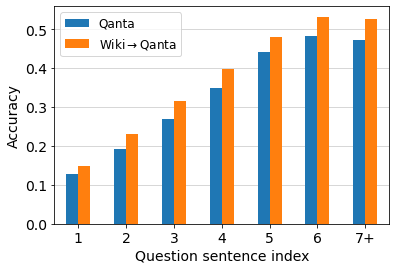

In [23]:
plt.figure()
ax = sid_accuracies_df.plot.bar(rot=0)
ax.grid(which='major', axis='y', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Question sentence index')
ax.set_ylabel('Accuracy')
ax.legend(fontsize=12)
plt.savefig('images/accuracy_sid.pdf', bbox_inches='tight')